<a href="https://colab.research.google.com/github/CrisLeaf/connect-4-bot/blob/master/classifier_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train a Connect 4 Classifier

Connect 4 is a two player board game, in which the players choose a color and then take turns dropping colored discs into a 6x7 grid. The objective of the game is to be the first to form a horizontal, vertical or diagonal line of four of one's own discs. 

Winning examples:

<img src="https://raw.githubusercontent.com/CrisLeaf/connect-4-bot/master/images/win1.jpeg" height=200, width=200>
<img src="https://raw.githubusercontent.com/CrisLeaf/connect-4-bot/master/images/win2.jpeg" height=200, width=200>
<img src="https://raw.githubusercontent.com/CrisLeaf/connect-4-bot/master/images/win3.jpeg" height=200, width=200>
<img src="https://raw.githubusercontent.com/CrisLeaf/connect-4-bot/master/images/win4.jpeg" height=200, width=200>

</br>
</br>
We are going to build a game classifier, which predicts when a game is going to be a win, a lose or a draw for a certain player. After that, one can also program a connect 4 bot using the game classifier to preempt each play.

Import initial libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Load Dataset

The dataset was downloaded from [kaggle](https://www.kaggle.com/tbrewer/connect-4), and it has:
* 376,640 rows, each represents the end results of a Connect 4 game.
* 1-42 columns are the positions on the grind from left to right, top to bottom. Each element in these columns represents the player's piece: 1, and -1 are players pieces, while 0 is an empty cell.
* Column 43 marks the winner of the game: 1, -1 and 0 for tie games.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/machine-learning/connect-4-bot/c4_game_database.csv")
df = df.sample(frac=1)
df = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376640 entries, 126595 to 127180
Data columns (total 43 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pos_01  376640 non-null  float64
 1   pos_02  376640 non-null  float64
 2   pos_03  376640 non-null  float64
 3   pos_04  376640 non-null  float64
 4   pos_05  376640 non-null  float64
 5   pos_06  376640 non-null  float64
 6   pos_07  376640 non-null  float64
 7   pos_08  376640 non-null  float64
 8   pos_09  376640 non-null  float64
 9   pos_10  376640 non-null  float64
 10  pos_11  376640 non-null  float64
 11  pos_12  376640 non-null  float64
 12  pos_13  376640 non-null  float64
 13  pos_14  376640 non-null  float64
 14  pos_15  376640 non-null  float64
 15  pos_16  376640 non-null  float64
 16  pos_17  376640 non-null  float64
 17  pos_18  376640 non-null  float64
 18  pos_19  376640 non-null  float64
 19  pos_20  376640 non-null  float64
 20  pos_21  376640 non-null  float64
 21  pos_2

## Exploratory Data Analysis

### Missing Values

In [ ]:
missing_num = sum(df["winner"].isna())
print(f"Number of missing values of winner column: {missing_num}")
print(f"Percentage of missing values of winner column: {missing_num/df.shape[0]:.2%}")

Number of missing values of winner column: 21
Percentage of missing values of winner column: 0.01%


Only 0.01% of rows in the `winner` column are missing. We drop them.



In [ ]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376619 entries, 0 to 376618
Data columns (total 43 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pos_01  376619 non-null  float64
 1   pos_02  376619 non-null  float64
 2   pos_03  376619 non-null  float64
 3   pos_04  376619 non-null  float64
 4   pos_05  376619 non-null  float64
 5   pos_06  376619 non-null  float64
 6   pos_07  376619 non-null  float64
 7   pos_08  376619 non-null  float64
 8   pos_09  376619 non-null  float64
 9   pos_10  376619 non-null  float64
 10  pos_11  376619 non-null  float64
 11  pos_12  376619 non-null  float64
 12  pos_13  376619 non-null  float64
 13  pos_14  376619 non-null  float64
 14  pos_15  376619 non-null  float64
 15  pos_16  376619 non-null  float64
 16  pos_17  376619 non-null  float64
 17  pos_18  376619 non-null  float64
 18  pos_19  376619 non-null  float64
 19  pos_20  376619 non-null  float64
 20  pos_21  376619 non-null  float64
 21  pos_22  37

### `winner` Statistics

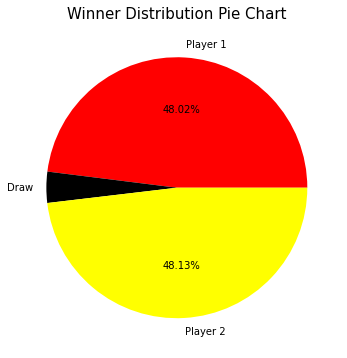

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Winner Distribution Pie Chart", fontsize=15)
plt.pie(df["winner"].value_counts().sort_index().values, labels=["Player 1", "Draw", "Player 2"],
        colors=["red", "black", "yellow"], autopct="%1.2f%%")
plt.show()

The majority of the games corresponds to a win or lose (depending on the player). And less than 4% corresponds to draw games. In that sense, we have an imbalanced dataset

### Games Statistics

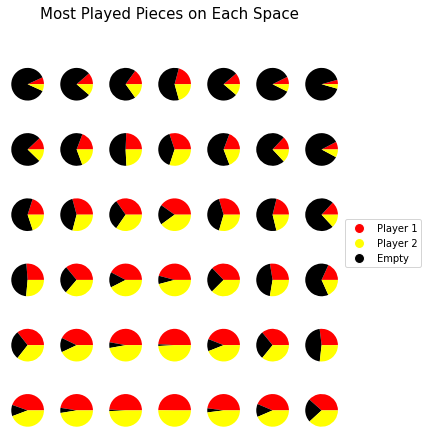

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, axes = plt.subplots(nrows=6, ncols=7, figsize=(6, 7))

i = 0
for j in range(42):
    axes[i, j % 7].pie(df.iloc[:, j].value_counts().sort_index().values, 
                       colors=["red", "black", "yellow"])
    if j % 7 == 6:
        i += 1

legend_elements = [Line2D([0], [0], marker="o", color="w", label="Player 1",
                          markerfacecolor="red", markersize=10),
                   Line2D([0], [0], marker="o", color="w", label="Player 2",
                          markerfacecolor="yellow", markersize=10),
                   Line2D([0], [0], marker="o", color="w", label="Empty",
                          markerfacecolor="black", markersize=10)]
axes[2, 6].legend(handles=legend_elements, loc="center", bbox_to_anchor=(2, -0.2))
fig.suptitle("Most Played Pieces on Each Space", fontsize=15)

plt.show()

## Classifier Train

Here we fit some well known classifiers to select the best scored one. Two of them being classical machine learning models, and due to the nature of the problem, the remaining four being tree-based models.

### Train Test Split

First split the dataset into 80% of Training and 20% of Testing.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="winner"), df["winner"],
                                                    test_size=0.2, random_state=1234)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(301295, 42) (75324, 42)
(301295,) (75324,)


### Model Selection

Now let's check the 5-cross validated score for each model. As the dataset has a low percentage of draw games, one need to use a suitable metric. In our case, we used the `f1_weighted` score, apporpiate for imbalanced multiclass classification problems.



#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(random_state=222)
scores = cross_val_score(logreg, X_train, y_train, scoring="f1_weighted", cv=5)
print(f"Logistic Regression CV Score: {np.mean(scores)}")

Logistic Regression CV Score: 0.8357280156852409


#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
scores = cross_val_score(gnb, X_train, y_train, scoring="f1_weighted", cv=5)
print(f"Naive Bayes CV Score: {np.mean(scores)}")

Naive Bayes CV Score: 0.634403737686353


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=222)
scores = cross_val_score(rfc, X_train, y_train, scoring="f1_weighted", cv=5)
print(f"Random Forest CV Score: {np.mean(scores)}")

Random Forest CV Score: 0.9683492914264769


#### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective="multi:softmax", num_class=3, random_state=222)
scores = cross_val_score(xgb, X_train, y_train, scoring="f1_weighted", cv=5)
print(f"XGBoost CV Score: {np.mean(scores)}")

XGBoost CV Score: 0.8129045596487721


#### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(objective="multiclass", random_state=222)
scores = cross_val_score(lgbm, X_train, y_train, scoring="f1_weighted", cv=5)
print(f"LightGBM CV Score: {np.mean(scores)}")

LightGBM CV Score: 0.9711861574040501


#### CatBoost

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

catb = CatBoostClassifier(verbose=0, random_state=222)
scores = cross_val_score(catb, X_train, y_train, scoring="f1_weighted", cv=5)
print(f"CatBoost CV Score: {np.mean(scores)}")

     |████████████████████████████████| 76.1 MB 69 kB/s 
CatBoost CV Score: 0.9980041906388333


#### Models Test

Test the model comparing the prediction on the `X_test` set with the `y_test` to be sure that the model is working well on new data. We compared the results ploting the confusion matrix.





In [ ]:
from sklearn.metrics import confusion_matrix

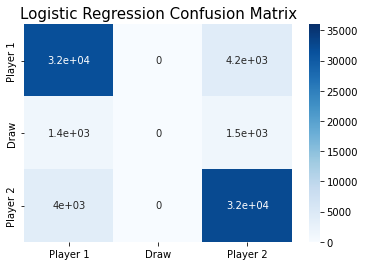

In [ ]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, cmap="Blues", vmin=0, vmax=36000, annot=True,
            xticklabels=["Player 1", "Draw", "Player 2"],
            yticklabels=["Player 1", "Draw", "Player 2"])
plt.title("Logistic Regression Confusion Matrix", fontsize=15)
plt.show()

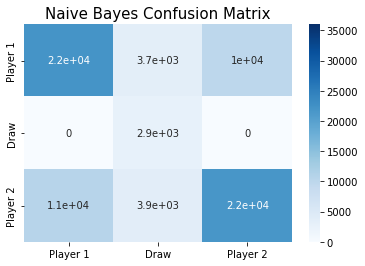

In [ ]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, cmap="Blues", vmin=0, vmax=36000, annot=True,
            xticklabels=["Player 1", "Draw", "Player 2"],
            yticklabels=["Player 1", "Draw", "Player 2"])
plt.title("Naive Bayes Confusion Matrix", fontsize=15)
plt.show()

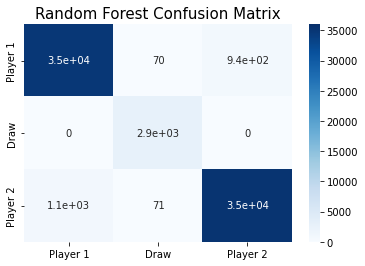

In [ ]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, cmap="Blues", vmin=0, vmax=36000, annot=True,
            xticklabels=["Player 1", "Draw", "Player 2"],
            yticklabels=["Player 1", "Draw", "Player 2"])
plt.title("Random Forest Confusion Matrix", fontsize=15)
plt.show()

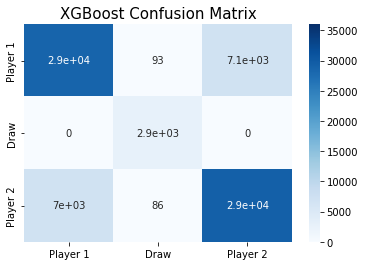

In [ ]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, cmap="Blues", vmin=0, vmax=36000, annot=True,
            xticklabels=["Player 1", "Draw", "Player 2"],
            yticklabels=["Player 1", "Draw", "Player 2"])
plt.title("XGBoost Confusion Matrix", fontsize=15)
plt.show()

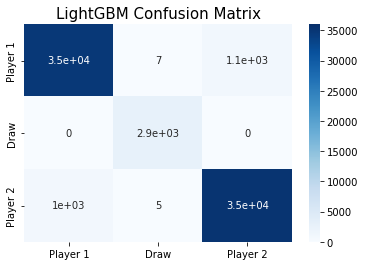

In [ ]:
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, cmap="Blues", vmin=0, vmax=36000, annot=True,
            xticklabels=["Player 1", "Draw", "Player 2"],
            yticklabels=["Player 1", "Draw", "Player 2"])
plt.title("LightGBM Confusion Matrix", fontsize=15)
plt.show()

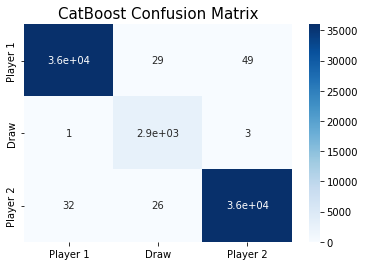

In [ ]:
catb.fit(X_train, y_train)
y_pred = catb.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, cmap="Blues", vmin=0, vmax=36000, annot=True,
            xticklabels=["Player 1", "Draw", "Player 2"],
            yticklabels=["Player 1", "Draw", "Player 2"])
plt.title("CatBoost Confusion Matrix", fontsize=15)
plt.show()

As we can see CatBoost Classifier got the best result in both training and testing datasets.

### Model Save

Save the model as a `classifier.pkl` file to not have to train it every time.



In [ ]:
catb = CatBoostClassifier(verbose=0, random_state=222)
catb.fit(df.drop(columns="winner"), df["winner"])

In [ ]:
import pickle

filename = "/content/gdrive/My Drive/machine-learning/connect-4-bot/classifier.pkl"
pickle.dump(catb, open(filename, "wb"))